# Randomized Greedy Algorithm

Reference paper: Michael Ovelgonne and Andreas Geyer-Schulz, *Cluster Cores and Modularity Maximization*, IEEE International Conference on Data Mining Workshops, 2010

## Formulacija problema

Neka je $G = (V, E)$ neusmereni graf, bez petlji i neka je $\mathcal{C} = \{C_1, \ldots, C_p\}$ nepreklapajuće klasterovanje, tj. klasterovanje čvorova grafa u grupe $C_i$ tako da $\forall i, j : i \neq j \implies C_i \cap C_j = \emptyset$ i $\cup_i C_i = V$.
Neka je $M$ matrica susedstva grafa $G$ (važi $m_{ij} = m_{ji} = 1$ ako $(v_i, v_j) \in E$, inače $m_{ij} = m_{ji} = 0$). 

Definišemo odnos broja grana koje povezuju klastere $C_i$ i $C_j$ i ukupnog broja grana kao 
$$e_{ij} = \frac{\sum_{v_x \in C_i} \sum_{v_y \in C_j} m_{xy}}{\sum_{v_x \in V} \sum_{v_y \in V} m_{xy}}.$$
Odnos broja grana u klasteru $C_i$ i ukupnog broja grana je $e_{ii}$.
Odnos stepen klastera $C_i$ (broj grana koje su incidentne sa bar jedanim čvorom iz klastera $C_i$) i ukupnog broja grana je dat sa
$$a_i = \sum_j e_{ij}.$$

Neka je $\mathcal{G}$ skup grafova sa istim čvorovima kao i graf $G$, pri čemu je stepen svakog čvora isti kao i u grafu $G$. Verovatnoća da se nasumična grana $(v_s, v_e)$ grafa iz $\mathcal{G}$ nađe u $C_i$ je data sa
$$P((v_s \in C_i) \land (v_e \in C_i)) = P(v_s \in C_i) P(v_e \in C_i) = a_i a_i = a_i^2.$$

Mera modularnosti nenasumičnosti klasterovanja može biti data kao
$$Q = \sum_i e_{ii} - a_i^2,$$
čiji je optimizacioni problem
$$\max_{\mathcal{C}} Q.$$
Ovaj problem je NP-težak.

## Drugi radovi

- Agarwal and Kempe: ILP (engl. Integer Linear Programming) formulacija
- Brendes et al.: ILP formulacija
- Agarwal and Kempe: LP (engl. Linear Programming) formulacija
  - Korisna za pronalaženje gornjih granica.
- Metaheuristike: Extremal optimization, simulated annealing, mean field annealing, tabu search, ground-state energy of spin system, stectral algorithms.
- Sakupljajuće klasterovanje: Počinjemo od pojedinačnih klastera (svaki klaster sadriži po jedan čvor). Iterativno spajamo po dva klastera sve dok ne ostane samo jedan klaster (koji sadriži sve čvorove). Ovim postupkom nasteje dendrogram (dijagram predstavlja drvo, gde svaki čvor predstavlja po jedno spajanje, a listovi pojedinačne elemente). Iz dendrograma biramo klasterovanje koje ima najveću modularnost.
  - Newman: U svakoj iteraciji spajamo dva klastera koja najviše utiču na promenu mere modularnosti.
  - Clauset et al.: Koriste Newman-ovu ideju ali je implementiraju na optimizovaniji način (PG (engl. Plain Greedy) algoritam).
  - Schuetz and Caflisch: MSG algritam (engl. MultiStep Greedy)
    - Mnogi parovi klaster su ekvivalentni u odnosu na promenu modularnosti pri njihovom spajanju.
    - U svakoj iteraciji spajamo sve parove klastera čije je promena modularnosti u $l$ najvećih.
    - Teško je odrediti parametar $l$.
  - Zhu et al.: MOME algoritam (coarsened graphs)
  - Blondel et al.: MSG algoritam BGLL koji ima dve faze u svakoj iteraciji:
    1. Prolazi kroz čvorove grafa gde svaki čvor pomera u susedni klaster tako da se poboljša modularnost sve dok ne dostignem lokalni optimum.
    2. Svaki klaster se transformiše u jedan čvor sa odgovarajućim težinskim granama.

### Učitavanje biblioteka

In [4]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

### Učitavanje instanci

In [5]:
def load_graph(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        tokens = lines[0].split()
        n, m = int(tokens[0]), int(tokens[1])
                        
        G = nx.Graph()
    
        nodes = np.arange(1, n + 1)
        G.add_nodes_from(nodes)
        
        for i in range(1, n + 1):
            neighbours = map(int, lines[i].split())
            for j in neighbours:
                G.add_edge(i, j)
                
        return G

In [6]:
file_paths = ['Instances/karate.graph', 'Instances/football.graph', 'Instances/netscience.graph', 'Instances/PGPgiantcompo.graph']
graphs = []

for file_path in file_paths:
        graphs.append(load_graph(file_path))

### Ciljna funkcija modularnosti

In [13]:
def number_of_connecting_edges(G, C, i, j):
    res = 0
    for u in C[i]:
        for v in C[j]:
            if G.has_edge(u, v):
                res += 1
    return res

def number_of_claster_edges(G, C, i):
    res = 0
    number_of_clasters = len(C)
    
    for j in C:
        res += number_of_connecting_edges(G, C, i, j)
    
    return res

def fraction_of_connecting_edges(G, C, i, j):
    return number_of_connecting_edges(G, C, i, j) / G.number_of_edges()
        
def fraction_of_claster_edges(G, C, i):
    return number_of_claster_edges(G, C, i) / G.number_of_edges()

def modularity(G, C):
    res = 0.0
    number_of_clasters = len(C)
    
    for i in C:
        res += (fraction_of_connecting_edges(G, C, i, i) - fraction_of_claster_edges(G, C, i)**2)
        
    return res

In [14]:
G = graphs[0]

C = {node: [node] for node in G.nodes()}

modularity(G, C)

-0.19921104536489145

## Plain Greedy (PG) algoritam

Sakupljajuće klasterovanje: Počinjemo od pojedinačnih klastera (svaki klaster sadriži po jedan čvor). Iterativno spajamo po dva klastera sve dok ne ostane samo jedan klaster (koji sadriži sve čvorove). Ovim postupkom nasteje dendrogram (dijagram predstavlja drvo, gde svaki čvor predstavlja po jedno spajanje, a listovi pojedinačne elemente). Iz dendrograma biramo klasterovanje koje ima najveću modularnost.
- Newman: U svakoj iteraciji spajamo dva klastera koja najviše utiču na promenu mere modularnosti.
- Clauset et al.: Koriste Newman-ovu ideju ali je implementiraju na optimizovaniji način (PG (engl. Plain Greedy) algoritam).

In [15]:
def has_connecting_edge(G, C, i, j):
    if (i not in C.keys()) or (j not in C.keys()):
        print('The key you are looking for is removed from the dictionary while merging some clusters!')
        return None
    
    for v in C[i]:
        for u in C[j]:
            if G.has_edge(u, v):
                return True
    return False

def join_for_plain_greedy(G, C, i, j):
    tmp=C[j]
    C[i]+=tmp
    C.pop(j)
    
def join(G, C, joins):
    for i, j in joins:
        join_for_plain_greedy(G, C, i, j)

C = {node: [node] for node in G.nodes()}
#join1(G, C, 1, 2)
print(C)
#join1(G,C, 3, 16)
print(C)

{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 27: [27], 28: [28], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34]}
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 27: [27], 28: [28], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34]}


In [16]:
# Initialising clasters
C = {node: [node] for node in G.nodes()}
print(C)
print('----------------------------------------------------------')
joins = []
modularity_values=[]
n=len(C)-1
for _ in range(n):
    next_join = (0, 0)
    max_delta_Q = -float('inf')
    modularity_values.append(modularity(G,C))
    for i in C:
        for j in C:
            if i >= j or (i, j) in joins:
                continue
            if not has_connecting_edge(G, C, i, j):
                continue
            delta_Q = 2 * (fraction_of_connecting_edges(G, C, i, j) - fraction_of_claster_edges(G, C, i) * fraction_of_claster_edges(G, C, j))
            if max_delta_Q < delta_Q:
                max_delta_Q = delta_Q
                next_join = (i, j)
                #join(G, C, i, j)
    joins.append(next_join)
    if next_join==(0,0):
        break
    join_for_plain_greedy(G, C, next_join[0], next_join[1])

#join(G, C, joins)
print(C)

{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 27: [27], 28: [28], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34]}
----------------------------------------------------------
{1: [1, 12, 5, 11, 6, 17, 7, 2, 18, 22, 20, 9, 31, 3, 10, 29, 4, 13, 8, 14, 15, 33, 16, 19, 21, 23, 27, 30, 34, 24, 28, 25, 26, 32]}


In [17]:
modularity(G, C)

-2.0

1
[-0.19921104536489145, -0.17619986850756075, -0.13280736357659434, -0.10979618671926362, -0.08711374095989481, -0.055555555555555546, -0.03287310979618672, 0.00657462195923738, 0.02827087442472062, 0.04865220249835636, 0.06837606837606838, 0.08744247205785666, 0.10650887573964496, 0.12557527942143323, 0.14398422090729773, 0.1617357001972386, 0.17948717948717943, 0.1959237343852728, 0.21170282708744245, 0.22682445759368833, 0.24194608809993426, 0.25575279421433267, 0.2695595003287311, 0.2827087442472058, 0.2955292570677186, 0.30802103879026954, 0.32117028270874437, 0.32708744247205795, 0.32018408941485876, 0.2984878369493755, 0.1637080867850101, 0.00690335305719933, -0.35502958579881627]


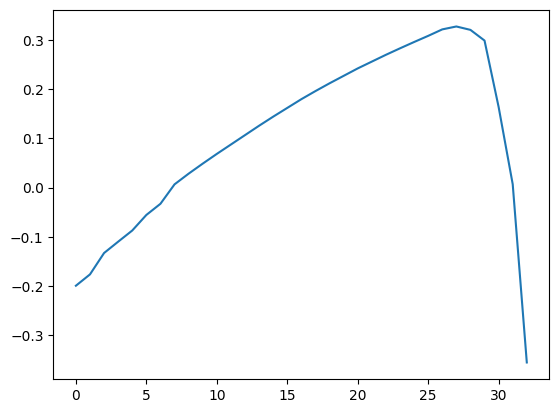

In [18]:
l=[1,2,3]
print(l[0])
print(modularity_values)
plt.plot(modularity_values)
plt.show()

In [19]:
#G.nodes()
#list(G.neighbors(5))
e=[]
a=[]
for node in G.nodes():
    e.append([])
    for neighbor in list(G.neighbors(node)):
        e[node-1].append(1/(2*len(G.edges())))
    sum=0
    for x in range(len(e[node-1])):
        sum+=x
    a.append(x)
print(a)    

[15, 8, 9, 5, 2, 3, 3, 3, 4, 1, 2, 0, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 2, 1, 3, 2, 3, 3, 5, 11, 16]


# Randomized Greedy (RG)

Gramizivi algoritam uvek prati smer najvećeg pozitivnog gradijenta. Spajanje dva klaster $C_i$ i $C_j$ rezultuje u promeni modularnosit za
$$\Delta Q (i, j) = e_{ij} + e_{ji} - 2 a_i a_j = 2 (e_{ij} - a_i a_j).$$
Povezivanjem dva nepovezana klaster $C_i$ i $C_j$ dobijamo negativnu promenu modularnosti, tj. $\Delta Q(i, j) < 0$. 

Ideja za poboljšanje PG algoritma:
1. Kretanje najstrmijim gradijentom ne garantuje pronalaženje dobrog rešenja.
2. Mnoga spajanja klastera imaju iste promene modularnosti.

RG algoritam pokušava da reši ove probleme: Interativno za $k$ nasumičnih klastera pretražuje njihove susede i bira one sa maksimalnom promenom modularnosit $\Delta Q$. 

Gramzivo poboljšanje predstavlja postprocesiranje u kome se menja najbolje klasterovanje (ono sa najvećom merom modularnosti) iz dendrogram. Pomeranjem čvorova u susedne klastere ako rezultuje u pozitivnoj promeni modularnosit $\Delta Q$. Postupak ponavljamo sve dok ima promene.

In [20]:
import sys
import copy
import numpy as np
import random
random.seed(7)

In [21]:
# Initialising our graph!
G = graphs[0]

C = {node: [node] for node in G.nodes()}

print(modularity(G, C))

-0.19921104536489145


In [22]:
print('-------------------------------------------------------------------------')
print(C)
print('-------------------------------------------------------------------------')
for i in C:
    print(i, end=' ')
print('-------------------------------------------------------------------------')
for i in C.keys():
    print(i, end=' ')

-------------------------------------------------------------------------
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 27: [27], 28: [28], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34]}
-------------------------------------------------------------------------
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 -------------------------------------------------------------------------
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 

In [23]:
def join_for_randomized_greedy(G, C, i, j):
    tmp=C[j]
    C[i]+=tmp
    C.pop(j)

In [24]:
# This function should pick k different clusters within the graph we are working with 
# and return the list of indeces of chosen clusters!
def pick_k_random_clusters(G, C, k):
    set_indexes=set()
    result=[]
    count = 0
    n=len(C.keys())
    if k>n:
        print('There are not that many clusters in our graph!')
        return None
    while count < k:
        p=random.randint(0, n)
        if p not in set_indexes:
            set_indexes.add(p)
            count+=1
            result.append(p)
            
    result.sort()
    
    return result  

def pick_random_cluster(G, C):
    help=list(C.keys())
    n=len(C.keys())
    return help[random.randint(0, n-1)]

In [25]:
# Here we just wanted to check the pick_k_random_clusters funtion!
k_clusters=pick_k_random_clusters(G, C, 6)
print(k_clusters)

[3, 4, 9, 20, 25, 34]


In [26]:
# Initialising clasters
C = {node: [node] for node in G.nodes()}
print(C)
print('----------------------------------------------------------')
joins = []
modularity_values=[]
clusters_list=[]
deleted=[]
count=1
n=len(C)
for p in range(n-1):
    next_join = (0, 0)
    max_delta_Q = -float('inf')
    if p < n//2:
        k=1
    else:
        k=2
    #random_k_clusters=pick_k_random_clusters(G, C, k)    
    modularity_values.append(modularity(G, C))
    clusters_list.append(copy.deepcopy(C))
    print('Iteration number: ', str(count))
    print('k = ', str(k))
    #for i in random_k_clusters:
    for _ in range(k):
        i=pick_random_cluster(G, C)
        for j in C.keys():
            if i==j:
                continue
                
            if not has_connecting_edge(G, C, i, j):
                continue
                
            #print(str(i)+ ' ' +str(j))
            
            delta_Q = 2 * (fraction_of_connecting_edges(G, C, i, j) - fraction_of_claster_edges(G, C, i) * fraction_of_claster_edges(G, C, j))
            if max_delta_Q < delta_Q:
                max_delta_Q = delta_Q
                next_join = (i, j)
    joins.append(next_join)
    if next_join==(0,0):
        continue
    join_for_randomized_greedy(G, C, next_join[0], next_join[1])
    count+=1

#join(G, C, joins)
print(C)

{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 27: [27], 28: [28], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34]}
----------------------------------------------------------
Iteration number:  1
k =  1
Iteration number:  2
k =  1
Iteration number:  3
k =  1
Iteration number:  4
k =  1
Iteration number:  5
k =  1
Iteration number:  6
k =  1
Iteration number:  7
k =  1
Iteration number:  8
k =  1
Iteration number:  9
k =  1
Iteration number:  10
k =  1
Iteration number:  11
k =  1
Iteration number:  12
k =  1
Iteration number:  13
k =  1
Iteration number:  14
k =  1
Iteration number:  15
k =  1
Iteration number:  16
k =  1
Iteration number:  17
k =  1
Iteration number:  18
k =  2
Iteration number:  19
k =  2
Iteration number:  20
k =  2
Iteration number:  21
k =  2
Iteration number: 

In [27]:
modularity(G, C)

-2.0

In [28]:
def RG(G, C):
    joins = []
    modularity_values=[]
    clusters_list=[]
    deleted=[]
    count=1
    n=len(C)
    for p in range(n-1):
        next_join = (0, 0)
        max_delta_Q = -float('inf')
        if p < n//2:
            k=1
        else:
            k=2
        #random_k_clusters=pick_k_random_clusters(G, C, k)    
        modularity_values.append(modularity(G, C))
        clusters_list.append(copy.deepcopy(C))
        for _ in range(k):
            i=pick_random_cluster(G, C)
            for j in C.keys():
                if i==j:
                    continue

                if not has_connecting_edge(G, C, i, j):
                    continue

                delta_Q = 2 * (fraction_of_connecting_edges(G, C, i, j) - fraction_of_claster_edges(G, C, i) * fraction_of_claster_edges(G, C, j))
                if max_delta_Q < delta_Q:
                    max_delta_Q = delta_Q
                    next_join = (i, j)
        joins.append(next_join)
        if next_join==(0,0):
            continue
        join_for_randomized_greedy(G, C, next_join[0], next_join[1])
        count+=1
    
    modularity_values=np.array(modularity_values)
    max_index=modularity_values.argmax()
    
    return clusters_list[max_index]

### Greedy refinement

Gramzivo poboljšanje predstavlja postprocesiranje u kome se menja najbolje klasterovanje (ono sa najvećom merom modularnosti) iz dendrogram. Pomeranjem čvorova u susedne klastere ako rezultuje u pozitivnoj promeni modularnosit $\Delta Q$. Postupak ponavljamo sve dok ima promene.

In [29]:
print(max(modularity_values))
modularity_values=np.array(modularity_values)
max_index=modularity_values.argmax()
print(max_index)
print(clusters_list[max_index])

0.32314266929651553
27
{9: [9, 31], 12: [12, 7, 17, 6, 5, 11, 1], 14: [14, 3, 10, 8, 4, 13], 18: [18, 22, 20, 2], 28: [28, 24, 25, 26, 32], 29: [29], 34: [34, 30, 27, 19, 21, 33, 15, 16, 23]}


[-0.19921105 -0.17619987 -0.15351742 -0.13182117 -0.11406969 -0.0973044
 -0.08218277 -0.06311637 -0.04043393 -0.02399737 -0.00887574  0.01084813
  0.01676529  0.06015779  0.08316897  0.1226167   0.15285996  0.16798159
  0.18704799  0.2061144   0.21597633  0.23372781  0.24753452  0.265286
  0.28106509  0.29355687  0.30670611  0.32314267  0.32018409  0.2896121
  0.21860618  0.04898093 -0.54832347]


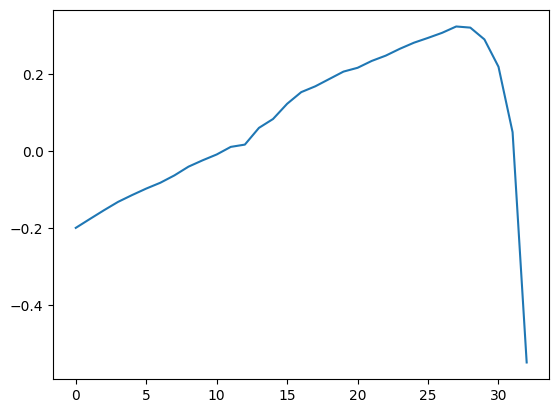

In [30]:
print(modularity_values)
plt.plot(modularity_values)
plt.show()

In [31]:
def find_coresponding_cluster(G, C, v):
    for k in C.keys():
         if v in C[k]:
                return k
    return None        
def move_delta_Q(G, C, v, cc, nc):
    Q1=modularity(G, C)
    #print('move_delta_Q function!')
    #print(v)
    #print(C[cc])
    #print(C[nc])
    CC=copy.deepcopy(C)
    CC[cc].remove(v)
    CC[nc].append(v)
    #print(CC[cc])
    #print(CC[nc])
    Q2=modularity(G, CC)
    return Q2-Q1

def neighbor_clusters(G, C, v, cc):            
    result=[]
    for k in C.keys():
        if k==cc:
            continue
        for x in C[k]:
            if (x, v) in G.edges() or (v, x) in G.edges():
                result.append(k)
    return result   
def move(G, C, v, cc, nc):
    #print('move function!')
    #print(v)
    #print(C[cc])
    #print(C[nc])
    #print('Little pause:')
    C[cc].remove(v)
    C[nc].append(v)
    #print(C[cc])
    #print(C[nc])

In [32]:
print(G.edges())
print(max(modularity_values))
C=clusters_list[max_index]
print('----------------------------------------------------------')
print(C)
print('Number of nodes in graph G is equal to: ', len(G.nodes()))

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (1, 12), (1, 13), (1, 14), (1, 18), (1, 20), (1, 22), (1, 32), (2, 3), (2, 4), (2, 8), (2, 14), (2, 18), (2, 20), (2, 22), (2, 31), (3, 4), (3, 8), (3, 9), (3, 10), (3, 14), (3, 28), (3, 29), (3, 33), (4, 8), (4, 13), (4, 14), (5, 7), (5, 11), (6, 7), (6, 11), (6, 17), (7, 17), (9, 31), (9, 33), (9, 34), (10, 34), (14, 34), (15, 33), (15, 34), (16, 33), (16, 34), (19, 33), (19, 34), (20, 34), (21, 33), (21, 34), (23, 33), (23, 34), (24, 26), (24, 28), (24, 30), (24, 33), (24, 34), (25, 26), (25, 28), (25, 32), (26, 32), (27, 30), (27, 34), (28, 34), (29, 32), (29, 34), (30, 33), (30, 34), (31, 33), (31, 34), (32, 33), (32, 34), (33, 34)]
0.32314266929651553
----------------------------------------------------------
{9: [9, 31], 12: [12, 7, 17, 6, 5, 11, 1], 14: [14, 3, 10, 8, 4, 13], 18: [18, 22, 20, 2], 28: [28, 24, 25, 26, 32], 29: [29], 34: [34, 30, 27, 19, 21, 33, 15, 16, 23]}
Number of nodes in graph G is eq

In [33]:
change=True
count=1
previous=None
while change:
    print('Iteration number: ', count)
    #print(C)
    change=False
    for v in G.nodes():
        current_cluster=find_coresponding_cluster(G, C, v)
        best_delta_Q=0
        star_cluster=None
        for neighbor_cluster in neighbor_clusters(G, C, v, current_cluster):
            delta_Q=move_delta_Q(G, C, v, current_cluster, neighbor_cluster)
            if delta_Q > best_delta_Q:
                best_delta_Q=delta_Q
                star_cluster=neighbor_cluster
        if best_delta_Q > 0:
            previous=C
            print('Here!')
            move(G, C, v, current_cluster, star_cluster)
            change=True
    count+=1        
print(C) 
print(modularity(G, C))

Iteration number:  1
Here!
Iteration number:  2
{9: [9, 31], 12: [12, 7, 17, 6, 5, 11, 1], 14: [14, 3, 10, 8, 4, 13], 18: [18, 22, 20, 2], 28: [28, 24, 25, 26, 32, 29], 29: [], 34: [34, 30, 27, 19, 21, 33, 15, 16, 23]}
0.3280736357659435


### Problem lokalnosti

Promena modularnosti $\Delta Q$ određuje koja dva klastera spojiti u odnosu na to kako su njihovi susedi već povezani.

Postupak spajanja je balansiran ako svi klasteri rastu podjednako, tj. veličina klastera nije korelisana sa verovatnoćom da klaster bude spojen u sledećem koraku. Maksimalnu nebalansiranost dobijamo kada jedan klaster raste, dok svi ostali ostaju pojedinačni.

Posledica nebalansiranog postupka spajanja je mreža gde su neki delovi mnogo više povezani od drugih, što direktno utiče na lokalnu pretragu gramzivog algoritma. Npr, svi susedi $v_2, v_3, v_4, v_5$ čvora $v_1$ imaju isti stepen, te je zbog toga $\Delta Q(v_1, v_j)$ isto za svako $j = 2, 3, 4, 5$. Ako su $v_2$ i $v_3$ već spojeni onda $\Delta Q(\{v_1\}, \{v_2, v_3\}) > \Delta Q(\{v_1\}, \{v_4\}) = \Delta Q (\{v_1\}, \{v_5\})$. Međutim, ako su $v_4$ i $v_5$ već spojeni, onda $\Delta Q(\{v_1\}, \{v_4, v_5\}) > \Delta Q(\{v_1\}, \{v_2\}) = \Delta Q(\{v_1\}, \{v_3\})$.

## Optimized randomized greedy algorithm (RG+ algorithm) 

Identifikovanje ključnih grupa. Svi čvorovi koji su povezani samo čvorovima istog klastera su unutrašnji čvorovi u datom kasteru. Svi čvorovi koji su povezani sa bar jednim čvorom drugog klastera su granični čvorovu u datom klasteru. 

Pretpostavka: Neki čvorovi će pripadati istoj grupi u svim mogućim klasterovanjima grafa. Identifikacija takvih čvorova i građenje odgovarajućih grupa dovodi do boljeg klasterovanja grafa. 

Neka je $\mathcal{P}^* = \{C^{*1}, \ldots, C^{*x}\}$ set svih klasterovanja gde je $Q(C^{*t})$ lokalni optimum. Tražimo par čvorova $v_i, v_j$ koji su deo nekog klastera za sva lokalno optimalna klasterovanja, tj. $\forall_x : v_i \in C_k^{*t} \implies v_j \in C_k^{*t}$. Algoritam delimo u dve faze:
1. Određivanje ključnih grupa: Naravno nije moguće izračunati $P^{*}$, jer bi tada znali klasterovanje sa maksimalnom modularnošću. Zbog toga, koristimo mali uzorak od $z$ klasterovanja sa visokom modularnošću. Njih je moguće dobiti pokretanjem RG algoritma (za svako inicijalno klasterovanje po jednom). Od inicijalnih klasterovanja, pravimo ključne grupe, tako što uzmemo prvo klasterovanje kao trenutni skup ključnih grupa. Iterativno delimo trenutni skup ključnih grupa pomoću novog klasterovanja. Neka je $g_{v_x, t}$  ključna grupa čvora $v_x$ u trenutku $t$ i $C_t(v_x)$ klaster čvora $v_x$ u klasterovanju $C_t$. Čvorovi $v_x$ i $v_y$ su u istorj trenutnoj ključnoj grupi nakon $t$ razdvajanja akko $g_{v_x, t-1} = g_{v_y, t-1} \land C_t(v_x) = C_t(v_y)$.
2. Klasterovanje ključnih grupa: Pokrenemo RG algoritam gde su ključne grupe početno klasterovanje.

In [34]:
import math

In [35]:
# Initialising our graph!
G = graphs[0]

C = {node: [node] for node in G.nodes()}

print(modularity(G, C))
print(C)

-0.19921104536489145
{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 27: [27], 28: [28], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34]}


In [36]:
# The first part of the Fast Randomized Greedy algorithm!
z=int(math.log(len(G.nodes())))
print(str(z))
optimal_clusterings=[]
#modularity_values, clustering_list=RG(G, C)
#modularity_values=np.array(modularity_values)
#used_modularity_values=set()
for i in range(z):
    C = {node: [node] for node in G.nodes()}
    optimal_clusterings.append(RG(G,C))
print(optimal_clusterings) 
print(len(optimal_clusterings))

3
[{7: [7, 17, 6, 11, 5], 10: [10, 3, 8, 4, 14, 2, 13], 18: [18], 20: [20], 22: [22, 12, 1], 25: [25, 26, 28, 24, 29, 32], 30: [30, 27], 31: [31, 9, 33, 15, 19, 23, 16, 34, 21]}, {2: [2, 18, 22], 12: [12, 5, 11, 7, 17, 6, 1], 14: [14, 3, 8, 13, 4], 19: [19, 21, 16, 23, 33, 15, 34, 10], 20: [20], 25: [25, 26, 32, 29, 28, 24, 30], 27: [27], 31: [31, 9]}, {3: [3, 10, 29, 14], 8: [8, 4, 13, 18, 22, 2, 20, 1], 9: [9, 31], 12: [12], 17: [17, 6, 7, 5, 11], 23: [23, 21, 33, 15, 16, 34, 30, 27, 19], 32: [32, 28, 24, 26, 25]}]
3


In [37]:
# This is the function that would be used in the second part of 
# the Fast Randomized Greedy algorithm implementation!
def merge_clusterings(core_clustering, current_clustering):
    new_core_clustering={}
    result_clusters=[]          
                
    # This way we will identify core clusters!
    for k1 in core_clustering.keys():
        for k2 in current_clustering.keys():
            if len(core_clustering[k1])==0:
                break
                
            tmp_set=set()
            while x in core_clustering[k1] and x in current_clustering[k2]:
                tmp_set.add(x)
                core_clustering[k1].remove(x)
                current_clustering[k2].remove(x)
            
            if(len(tmp_set))!=0:
                result_clusters.append(list(tmp_set))
            
            if len(core_clustering[k1])==0:
                break
    
    # Everything else that is still in the one dictionary or the other 
    # should be added to result_clusters list            
    for k1 in core_clustering.keys():
        if len(core_clustering[k1])!=0:
            result_clusters.append(core_clustering[k1])
    
    # Now when we have all clusters stored in a list, we need to create a dictionary from that list!
    index=1
    for cluster in result_clusters:
        new_core_clustering[index]=cluster
        index+=1
    
    return new_core_clustering        

In [38]:
# Just to check something!
l1=[1, 2, 9, 4, 4, 4]
l2=[1, 2, 6, 7, 9]
l3=[1, 2, 4, 5]
if l1==l2:
    print('Lists are identical!')
else:
    print('Lists are not identical!')

if l1<l3:
    print('Wow, we can do that too!')

Lists are not identical!


In [39]:
# The second part of the Fast Randomized Greedy algorithm!
core_clustering=optimal_clusterings[0]
print(core_clustering)
print('--------------------------------------------------------------------')
for i in range(1, len(optimal_clusterings)):
    core_clustering=merge_clusterings(core_clustering, optimal_clusterings[i])
print(core_clustering)    

{7: [7, 17, 6, 11, 5], 10: [10, 3, 8, 4, 14, 2, 13], 18: [18], 20: [20], 22: [22, 12, 1], 25: [25, 26, 28, 24, 29, 32], 30: [30, 27], 31: [31, 9, 33, 15, 19, 23, 16, 34, 21]}
--------------------------------------------------------------------
{1: [16], 2: [7, 17, 6, 11, 5], 3: [10, 3, 8, 4, 14, 2, 13], 4: [18], 5: [20], 6: [22, 12, 1], 7: [25, 26, 28, 24, 29, 32], 8: [30, 27], 9: [31, 9, 33, 15, 19, 23, 34, 21]}


In [40]:
# Here is the modularity we get when we apply RG algorithm after we applied RG+!
# We get better results which was our intention at the first place!
X=RG(G, core_clustering)
print(X)
print(modularity(G, X))

{2: [7, 17, 6, 11, 5, 22, 12, 1, 18], 3: [10, 3, 8, 4, 14, 2, 13], 5: [20], 7: [25, 26, 28, 24, 29, 32], 8: [30, 27], 9: [31, 9, 33, 15, 19, 23, 34, 21, 16]}
0.2876397107166337


In [41]:
# Here is the modularity we receive after applying RG algorithm on initial clustering state!
# As you can see, we got lower modularity value in comparison with aboce cell!
G = graphs[0]

C = {node: [node] for node in G.nodes()}
X=RG(G, C)
print(X)
print(modularity(G, X))

{7: [7, 17, 6, 11, 5], 9: [9, 31], 13: [13, 14, 8, 4, 3, 10], 22: [22, 20, 2, 18, 12, 1], 28: [28, 24, 26, 32, 25, 29], 30: [30, 27, 34, 23, 21, 15, 19, 33, 16]}
0.3280736357659435


In [42]:
# In this cell we will sumarize whole work of RG+ algorithm!
def fast_RG(G, C):
    # The first part of the Fast Randomized Greedy algorithm!
    z=int(math.log(len(G.nodes())))
    optimal_clusterings=[]
    for i in range(z):
        C = {node: [node] for node in G.nodes()}
        optimal_clusterings.append(RG(G,C))
    
    # Some extra outputs we used to track the work of RG+ algorithm!
    #print(optimal_clusterings) 
    #print(len(optimal_clusterings))
    
    # The second part of the Fast Randomized Greedy algorithm!
    core_clustering=optimal_clusterings[0]
    for i in range(1, len(optimal_clusterings)):
        core_clustering=merge_clusterings(core_clustering, optimal_clusterings[i])
    
    #print(core_clustering) 
    core_clustering=RG(G, core_clustering)
    
    return core_clustering

# Testing results of RG and RG+ to see which one works better!

In [ ]:
print('The number of graphs we are working with is equal to: ', len(graphs))
pairs_of_results=[]
count=1
for G in graphs:
    print('----------------------------------------------------')
    print('We are processing graph number ', count, '!')
    print('This graph contains ', len(G.nodes()), ' nodes!')
    print('This graph contains ', len(G.edges()), ' edges!')
    fast_rg_points=0
    rg_points=0
    for i in range(100):
        C1={node: [node] for node in G.nodes()}
        C2={node: [node] for node in G.nodes()}
        rg_result=RG(G,C1)
        fast_rg_result=fast_RG(G, C2)
        if modularity(G, fast_rg_result)>modularity(G, rg_result):
            #print('True!', end=' ')
            fast_rg_points+=1
        else:
            #print('False!', end=' ')
            rg_points+=1    
        pairs_of_results.append((modularity(G, fast_rg_result), modularity(G, rg_result)))
    print('\tGraph number ', count, 'is processed!')
    print('Total score for RG+ algortihm: ', fast_rg_points)
    print('Total score for RG algorithm: ', rg_points)
    count+=1

print('Number of pairs we will process is equal to: ', len(pairs_of_results))        
for pair in pairs_of_results:
    if pair[0]>pair[1]:
        print('True', end=' ')
    else:
        print('False', end=' ')

The number of graphs we are working with is equal to:  4
----------------------------------------------------
We are processing graph number  1 !
This graph contains  34  nodes!
This graph contains  78  edges!
	Graph number  1 is processed!
Total score for RG+ algortihm:  62
Total score for RG algorithm:  38
----------------------------------------------------
We are processing graph number  2 !
This graph contains  115  nodes!
This graph contains  613  edges!
	Graph number  2 is processed!
Total score for RG+ algortihm:  71
Total score for RG algorithm:  29
----------------------------------------------------
We are processing graph number  3 !
This graph contains  1589  nodes!
This graph contains  2742  edges!
